## Application of deep learning approach to classify SARS-CoV-2 variants


### Coding Notebook
### Install and load the following libraries and packages

In [31]:
import pandas as pd
import numpy as np
import os
import joblib
import random
import tensorflow as tf
from keras import utils as np_utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier  
import keras
from keras import utils as np_utils
from numpy import array
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score,ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, GRU, LSTM
from keras.layers import Dense, Concatenate, Flatten
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import time

In [32]:
# Set seeds
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
print(keras.__version__)

3.10.0


### Loading datasets and preprocessing

dataset_2 - sequence dataset with over 26000 used for training and validating the model <br>
dataset_3 - sequences to validate the model


In [34]:
dataset_2 = '../data/sequences.aln.fas' # huge dataset with 26k sequences
dataset_3 = '../data/validation.sequences.fas'

In [35]:
#Converting sequence data into data frame
#Ensure the fasta sequences are in one-liner and not blocks
#The sequence file had been pre-processed to include varinat names in the sequnce headers. Check file in fasta format.

#inputfile = [dataset_2,dataset_3]

def preprocess(inputfile):
    lines = []
    header = []
    with open (inputfile, 'r') as fasta_file:
    
        for line in fasta_file:
            if line.startswith(">"):
            #extract fasta headers
                lines.append(line.replace('\w', '').replace(">", "").replace("\n", ''))
            
            next
            #extract sequence lines
            if not line.startswith(">"):
                header.append(line.replace("\n",''))

            
    #Create dictionary of header and sequences and create a dataframe
    data = {lines[i]:header[i] for i in range(len(header))}
    data = pd.DataFrame(list(data.items()),columns = ['Seq_ID','sequence']) 

    data["sequence"] = data["sequence"].str.upper() #ensure the sequence is un uppercase. Important for encoding
    data["Variant_Id"] = data["Seq_ID"].apply(lambda i: i.split('/')[0]) #extracting variant names from sequnce file
    data = data.drop("Seq_ID", axis=1)
    
    return data



dataset_2 = preprocess(dataset_2)
dataset_3 = preprocess(dataset_3)


<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\w'
C:\Users\MHC V(D)J\AppData\Local\Temp\ipykernel_6056\2666058838.py:15: SyntaxWarning: invalid escape sequence '\w'
  lines.append(line.replace('\w', '').replace(">", "").replace("\n", ''))


📊 Training dataset - sample count per class:
Variant_Id
Gamma      5597
Alpha      5511
Delta      5495
Omicron    5162
Beta       4271
Name: count, dtype: int64

🧮 Total sequences in training dataset: 26036

📊 Validation dataset - sample count per class:
Variant_Id
Beta       1403
Alpha       625
Delta       494
Gamma       437
Omicron     103
Name: count, dtype: int64

🧮 Total sequences in validation dataset: 3062

📝 Variant counts saved to: variant_distribution\variant_counts.txt


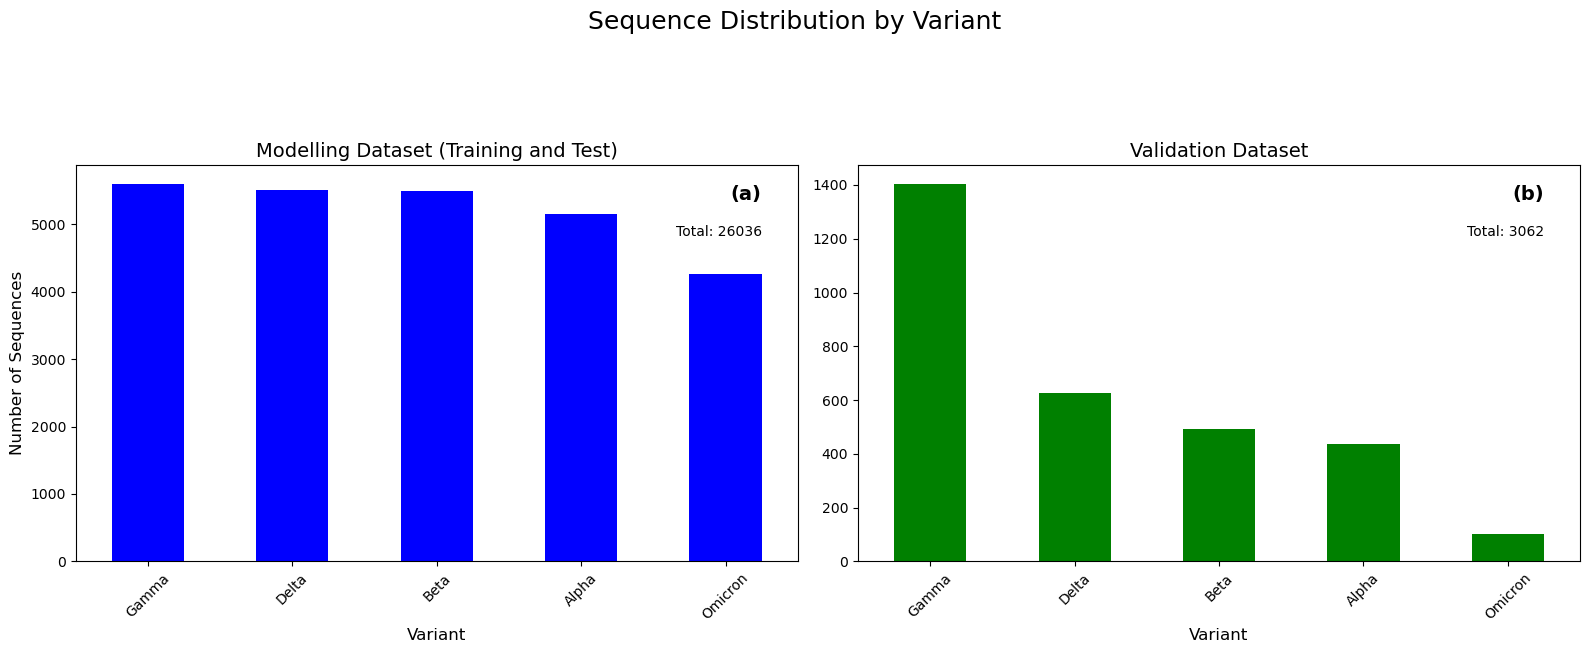

In [39]:
# Create output directory
output_dir = "variant_distribution"
os.makedirs(output_dir, exist_ok=True)

# Capitalize variant names
dataset_2["Variant_Id"] = dataset_2["Variant_Id"].astype(str).str.capitalize()
dataset_3["Variant_Id"] = dataset_3["Variant_Id"].astype(str).str.capitalize()

# Count variant IDs
class_counts_2 = dataset_2["Variant_Id"].value_counts()
total_count_2 = class_counts_2.sum()

class_counts_3 = dataset_3["Variant_Id"].value_counts()
total_count_3 = class_counts_3.sum()

# Print counts
print("📊 Training dataset - sample count per class:")
print(class_counts_2)
print(f"\n🧮 Total sequences in training dataset: {total_count_2}\n")

print("📊 Validation dataset - sample count per class:")
print(class_counts_3)
print(f"\n🧮 Total sequences in validation dataset: {total_count_3}\n")

# Save counts to a text file
counts_path = os.path.join(output_dir, "variant_counts.txt")
with open(counts_path, 'w') as f:
    f.write("Training Dataset (dataset_2):\n")
    f.write(class_counts_2.to_string())
    f.write(f"\n\nTotal: {total_count_2}\n\n")
    
    f.write("Validation Dataset (dataset_3):\n")
    f.write(class_counts_3.to_string())
    f.write(f"\n\nTotal: {total_count_3}\n")

print(f"📝 Variant counts saved to: {counts_path}")

# Plot both in subplots with independent y-scales
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Sequence Distribution by Variant", fontsize=18, y=1.08)

# Plot 1: Training/Test
class_counts_2.plot(kind="bar", color="blue", ax=axes[0])
axes[0].set_title("Modelling Dataset (Training and Test)", fontsize=14)
axes[0].set_xlabel("Variant", fontsize=12)
axes[0].set_ylabel("Number of Sequences", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xticklabels(variant_order)
axes[0].text(0.95, 0.95, "(a)", transform=axes[0].transAxes,
             fontsize=14, fontweight='bold', va='top', ha='right')
axes[0].text(0.95, 0.85, f"Total: {total_count_2}", transform=axes[0].transAxes,
             fontsize=10, va='top', ha='right',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Plot 2: Validation
class_counts_3.plot(kind="bar", color="green", ax=axes[1])
axes[1].set_title("Validation Dataset", fontsize=14)
axes[1].set_xlabel("Variant", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xticklabels(variant_order)
axes[1].text(0.95, 0.95, "(b)", transform=axes[1].transAxes,
             fontsize=14, fontweight='bold', va='top', ha='right')
axes[1].text(0.95, 0.85, f"Total: {total_count_3}", transform=axes[1].transAxes,
             fontsize=10, va='top', ha='right',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and show
plot_path = os.path.join(output_dir, "variant_distribution_combined_independent_y.png")
plt.savefig(plot_path, dpi=600, bbox_inches='tight', format='png')
plt.show()



In [ ]:
# Plot both in subplots with independent y-scales
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Independent y-scale
fig.suptitle("Sequence Distribution by Variant", fontsize=18, y=1.02)

# Training plot
class_counts_2.plot(kind="bar", color="blue", ax=axes[0])
axes[0].set_title("Modelling Dataset (Training and Test)", fontsize=14)
axes[0].set_xlabel("Variant", fontsize=12)
axes[0].set_ylabel("Number of Sequences", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].text(0.95, 0.95, f"Total: {total_count_2}", transform=axes[0].transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Validation plot
class_counts_3.plot(kind="bar", color="green", ax=axes[1])
axes[1].set_title("Validation Dataset", fontsize=14)
axes[1].set_xlabel("Variant", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].text(0.95, 0.95, f"Total: {total_count_3}", transform=axes[1].transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for main title


Plot number of sequences for each variant

### Assign variant name to numerical form

gamma - 0 \
delta - 1 \
beta - 2 \
alpha - 3 \
omicron - 4

In [7]:
def variant_to_numerical(sequence_data):
    """
    Function to map convetional variant names to numeric
    pass a sequence data with column named "Variant_ID".
    
    """
    
    variant = {"Gamma" : 0, "Delta" : 1, "Beta" : 2, "Alpha" : 3, "Omicron":4}
    
    
    sequence_data["Variant_Id"] = sequence_data["Variant_Id"].map(variant)
    
    return sequence_data
    

In [8]:
variant_to_numerical(dataset_2)

dataset_2.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3


In [9]:
def encode_seq(seq_data):
    """
    Function to convert nucleotides to binary form and hot-encoded

    Arguments :
    seq_data = sequence dataframe with "sequence" and "Variant_ID" columns

    char : total number of unique characters in the whole dataset. This is used to 
    bin : array list of zeros corresponding to the number of characters

    """

    ntds = []
    for i in seq_data['sequence']:
        for seq in i:
            ntd = seq.strip()
            ntds.append(ntd.upper())
        
    char = list(set(ntds))
    
    bin = [0] * len(char)
    bin0  = [0] * len(char)
    bin1  = [0] * len(char)
    bin2  = [0] * len(char)
    bin3  = [0] * len(char)
    
    #Create a dictionary of arrays to the seqeunce characters
    Encode = {}

    for i in char:
        if i == 'A':
            bin0[0] = 1
            Encode[i] = bin0
        elif i == 'C':
            bin1[1] = 1
            Encode[i] = bin1
        elif i == 'G':
            bin2[2] = 1
            Encode[i] = bin2
        elif i == 'T':
            bin3[3] = 1
            Encode[i] = bin3
        else:
            Encode[i] = bin
    
      #convert the sequence characters to encoded form and append to the list

    encoded_list = []

    for seq in seq_data["sequence"]:
        encoded_list.append([Encode[x] for x in seq])

    return encoded_list

### Encoding sequences

In [10]:
#call function to encode the sequences and convert to array form
X_mine_data_kmer_2 = np.array(encode_seq(dataset_2))

#np.save("../../my_array", X_mine_data_kmer) #just setting DIR where to store this. Next time no need to run the process again

#X_mine_data_kmer_2 = np.load("../../my_array.npy")


In [11]:
#set variable for 
y_mine_kmer_2 = dataset_2['Variant_Id']

#y_mine_kmer_2.shape

In [12]:
# Leave-One-Variant-Out: exclude Omicron (label 4) from training
leave_out_label = 1  # Omicron is encoded as 4

# Create a mask for all data that is NOT Omicron
train_mask = y_mine_kmer_2 != leave_out_label
test_mask = y_mine_kmer_2 == leave_out_label

# Apply mask to X and y
X_mine_data_kmer_2_lovo = X_mine_data_kmer_2[train_mask]
y_mine_kmer_2_lovo = y_mine_kmer_2[train_mask]

X_test_gamma = X_mine_data_kmer_2[test_mask]
y_test_gamma = y_mine_kmer_2[test_mask]


In [13]:
dataset_2.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3


### **Model Fitting**
Split the dataset into training and validation (80:20) ration.

In [14]:
# Perform train/val split only on data excluding Omicron
X_train, X_test, y_train, y_test = train_test_split(
    X_mine_data_kmer_2_lovo,
    y_mine_kmer_2_lovo,
    test_size=0.2,
    stratify=y_mine_kmer_2_lovo,
    random_state=42
)
# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [15]:
X_train.shape

(16432, 3854, 13)

In [16]:
X_test.shape

(4109, 3854, 13)

In [17]:
# Sanity check: ensure Omicron (label = 4) is not in training or validation labels
print("Unique labels in training set:", np.unique(np.argmax(y_train, axis=1)))
print("Unique labels in test set:", np.unique(np.argmax(y_test, axis=1)))

Unique labels in training set: [0 2 3 4]
Unique labels in test set: [0 2 3 4]


Set the model 

In [18]:
# Define input shape
input_layer = Input(shape=X_mine_data_kmer_2.shape[1:])

# Shared CNN layers
x = Conv1D(filters=54, kernel_size=6, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=5)(x)
x = Dropout(0.5)(x)

x = Conv1D(filters=27, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.2)(x)

x = Conv1D(filters=14, kernel_size=2, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.1)(x)

x = Conv1D(filters=7, kernel_size=2, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3)(x)

# BiLSTM branch only
x = Bidirectional(LSTM(512))(x)
x = Dropout(0.01)(x)

# Dense layers (unchanged)
x = Dense(256, activation='relu')(x)
x = Dense(128)(x)
x = Dense(64)(x)
x = Dense(32)(x)
x = Dense(16)(x)

# Output layer
output = Dense(5, activation='softmax')(x)

# Define the model
cnn_bilstm_model = Model(inputs=input_layer, outputs=output)

# Compile the model
cnn_bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
cnn_bilstm_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3854, 13)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 3849, 54)            │           4,266 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 769, 54)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 769, 54)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 769, 27)             │           4,401 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 256, 27)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256, 27)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 256, 14)             │             770 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 85, 14)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 85, 14)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 85, 7)               │             203 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 28, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1024)                │       2,129,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,445,805 (9.33 MB)

 Trainable params: 2,445,805 (9.33 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Fit the model on the dataset
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=8,
    restore_best_weights=True
)
start_time = time.time()
history = cnn_bilstm_model.fit(
    X_train, y_train,
    batch_size=1000,
    validation_data=(X_test, y_test),  # <--- use filtered validation set
    epochs=30,
    callbacks=[early_stop]
)
train_duration = time.time() - start_time
print(f"✅ Training time: {train_duration:.2f} seconds")

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.2052 - loss: 1.4922 - val_accuracy: 0.2682 - val_loss: 1.4060
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.2800 - loss: 1.3887 - val_accuracy: 0.2726 - val_loss: 1.4010
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.2702 - loss: 1.3844 - val_accuracy: 0.2682 - val_loss: 1.4100
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.2763 - loss: 1.3828 - val_accuracy: 0.2682 - val_loss: 1.3994
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.2758 - loss: 1.3830 - val_accuracy: 0.2716 - val_loss: 1.3977
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.2811 - loss: 1.3799 - val_accuracy: 0.4551 - val_loss: 1.3880
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.2989 - loss: 1.3742 - val_accuracy: 0.7428 - val_loss: 1.2512
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.3228 - loss: 1.3696 - val_accuracy: 0.7398 - val_loss:

In [20]:
# save the model to disk
#filename = 'cnn_model.sav'
#joblib.dump(cnn_model, 'cnn_model.sav')
 
# load the model from disk
#cnn_model_c = joblib.load(filename)


In [21]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss

# ========== Timer for evaluation ==========
eval_start = time.time()

# ========== Set up output paths ==========
variant_names = ["Gamma", "Delta", "Beta", "Alpha", "Omicron"]
left_out_variant = variant_names[leave_out_label]
base_output_dir = f"results/leave_out_{left_out_variant}/test_evaluation"
os.makedirs(base_output_dir, exist_ok=True)

# ========== Prediction ==========
y_pred_probs = cnn_bilstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# ========== Classification Report ==========
target_names = [v for i, v in enumerate(variant_names) if i != leave_out_label]  # Exclude omitted variant
report = classification_report(y_true_classes, y_pred_classes, target_names=target_names, zero_division=0)
with open(os.path.join(base_output_dir, "classification_report.txt"), "w") as f:
    f.write(report)

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=target_names, yticklabels=target_names)
plt.title(f"Confusion Matrix - Test - Left out {left_out_variant}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(base_output_dir, "confusion_matrix.png"), dpi=600)
plt.close()

# Save raw confusion matrix
np.savetxt(os.path.join(base_output_dir, "confusion_matrix_raw.txt"), cm, fmt="%d")

# ========== Accuracy and Log Loss ==========
# ========== Accuracy and Log Loss ==========
acc = accuracy_score(y_true_classes, y_pred_classes)

# Remove the Omicron column (class 4)
y_pred_probs_trimmed = y_pred_probs[:, :4]

# Compute log loss only on the classes present in test set
loss = log_loss(y_true_classes, y_pred_probs_trimmed, labels=[0, 1, 2, 3])


# ========== Training History Plot ==========
plt.figure()
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(base_output_dir, "accuracy_curve.png"), dpi=600)
plt.close()

plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(base_output_dir, "loss_curve.png"), dpi=600)
plt.close()

# ========== Evaluation Timing ==========
eval_end = time.time()
with open(os.path.join(base_output_dir, "time_log.txt"), "w") as f:
    f.write(f"Total Evaluation Time: {eval_end - eval_start:.2f} seconds\n")


129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [22]:
variant_to_numerical(dataset_3)

dataset_3.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3


In [23]:
#call function to encode the sequences and convert to array form
X_mine_data_kmer_3 = np.array(encode_seq(dataset_3))

#np.save("../../my_array_3", X_mine_data_kmer) #just setting DIR where to store this. Next time no need to run the process again

#X_mine_data_kmer_3 = np.load("../../my_array_3.npy")

In [24]:
Y_pred = cnn_bilstm_model.predict(X_mine_data_kmer_3)


96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step


In [25]:
# Convert predictions classes to one hot vectors 
#set variable for

y_mine_kmer_3 = dataset_3['Variant_Id'] 
y_mine_kmer_3 = np.array(y_mine_kmer_3)
y_mine_kmer_3

Y_pred_values = (Y_pred > 0.5)
Y_pred_values = np.argmax(Y_pred, axis=1)


val = f1_score(Y_pred_values, y_mine_kmer_3,average='weighted' )
print("F1 score for the model is", val)

F1 score for the model is 0.8630181991131485


In [26]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, f1_score

# ========= Timer =========
val_start = time.time()

# ========= Prepare validation input =========
X_mine_data_kmer_3 = np.array(encode_seq(dataset_3))
y_mine_kmer_3 = np.array(dataset_3['Variant_Id'])

# ========= Predict and apply confidence threshold =========
confidence_threshold = 0.603158
Y_pred_probs = cnn_bilstm_model.predict(X_mine_data_kmer_3)
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)
Y_max_probs = np.max(Y_pred_probs, axis=1)

# Flag low-confidence predictions as "Unknown" (-1)
Y_pred_classes_flagged = np.where(Y_max_probs >= confidence_threshold, Y_pred_classes, -1)

# ========= Directory setup =========
variant_names = ["Gamma", "Delta", "Beta", "Alpha", "Omicron"]
left_out_variant = variant_names[leave_out_label]
all_class_names = variant_names + ["Unknown"]

val_output_dir = f"results/leave_out_{left_out_variant}/validation_evaluation"
os.makedirs(val_output_dir, exist_ok=True)

# ========= Classification Report =========
report_val = classification_report(
    y_mine_kmer_3, 
    Y_pred_classes_flagged, 
    labels=[0, 1, 2, 3, 4, -1], 
    target_names=all_class_names, 
    zero_division=0
)

with open(os.path.join(val_output_dir, "classification_report.txt"), "w") as f:
    f.write(report_val)

# ========= Confusion Matrix =========
cm_val = confusion_matrix(y_mine_kmer_3, Y_pred_classes_flagged, labels=[0, 1, 2, 3, 4, -1])

plt.figure(figsize=(7, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=all_class_names, yticklabels=variant_names + ["Unknown"])
plt.title(f"Confusion Matrix - Validation - Left out {left_out_variant}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(val_output_dir, "confusion_matrix.png"), dpi=600)
plt.close()

# Save raw matrix
np.savetxt(os.path.join(val_output_dir, "confusion_matrix_raw.txt"), cm_val, fmt="%d")

# ========= Metrics =========
# Exclude "Unknown" for metrics like accuracy/f1
filtered_idxs = Y_pred_classes_flagged != -1
val_acc = accuracy_score(y_mine_kmer_3[filtered_idxs], Y_pred_classes_flagged[filtered_idxs])
val_loss = log_loss(y_mine_kmer_3, Y_pred_probs, labels=[0, 1, 2, 3, 4])  # still use full probs
val_f1 = f1_score(y_mine_kmer_3[filtered_idxs], Y_pred_classes_flagged[filtered_idxs], average='weighted')

with open(os.path.join(val_output_dir, "metrics_summary.txt"), "w") as f:
    f.write(f"Accuracy (excluding Unknown): {val_acc:.4f}\n")
    f.write(f"Log Loss: {val_loss:.4f}\n")
    f.write(f"F1 Score (weighted, excluding Unknown): {val_f1:.4f}\n")
    f.write(f"Flagged as Unknown: {(Y_pred_classes_flagged == -1).sum()} samples\n")

# ========= Timing =========
val_end = time.time()
with open(os.path.join(val_output_dir, "time_log.txt"), "w") as f:
    f.write(f"Total Validation Evaluation Time: {val_end - val_start:.2f} seconds\n")

print(f"✅ Validation evaluation complete with confidence flagging. Results saved to: {val_output_dir}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step
✅ Validation evaluation complete with confidence flagging. Results saved to: results/leave_out_Delta/validation_evaluation


In [27]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, f1_score

# ========= Timer =========
val_start = time.time()

# ========= Prepare validation input =========
X_mine_data_kmer_3 = np.array(encode_seq(dataset_3))
y_mine_kmer_3 = np.array(dataset_3['Variant_Id'])

# ========= Predict =========
Y_pred_probs = cnn_bilstm_model.predict(X_mine_data_kmer_3)
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)

# ========= Directory setup =========
variant_names = ["Gamma", "Delta", "Beta", "Alpha", "Omicron"]
left_out_variant = variant_names[leave_out_label]

val_output_dir = f"results/leave_out_{left_out_variant}/validation_evaluation"
os.makedirs(val_output_dir, exist_ok=True)

# ========= Classification Report =========
report_val = classification_report(y_mine_kmer_3, Y_pred_classes, target_names=variant_names, zero_division=0)
with open(os.path.join(val_output_dir, "classification_report.txt"), "w") as f:
    f.write(report_val)

# ========= Confusion Matrix =========
cm_val = confusion_matrix(y_mine_kmer_3, Y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=variant_names, yticklabels=variant_names)
plt.title(f"Confusion Matrix - Validation - Left out {left_out_variant}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(val_output_dir, "confusion_matrix1.png"), dpi=600)
plt.close()

# Save raw matrix
np.savetxt(os.path.join(val_output_dir, "confusion_matrix_raw.txt"), cm_val, fmt="%d")

# ========= Metrics =========
val_acc = accuracy_score(y_mine_kmer_3, Y_pred_classes)
val_loss = log_loss(y_mine_kmer_3, Y_pred_probs, labels=[0, 1, 2, 3, 4])
val_f1 = f1_score(y_mine_kmer_3, Y_pred_classes, average='weighted')

with open(os.path.join(val_output_dir, "metrics_summary.txt"), "w") as f:
    f.write(f"Accuracy: {val_acc:.4f}\n")
    f.write(f"Log Loss: {val_loss:.4f}\n")
    f.write(f"F1 Score (weighted): {val_f1:.4f}\n")

# ========= Timing =========
val_end = time.time()
with open(os.path.join(val_output_dir, "time_log.txt"), "w") as f:
    f.write(f"Total Validation Evaluation Time: {val_end - val_start:.2f} seconds\n")

print(f"✅ Validation evaluation complete. Results saved to: {val_output_dir}")


96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
✅ Validation evaluation complete. Results saved to: results/leave_out_Delta/validation_evaluation
